In [14]:
import pandas as pd

data = pd.read_excel('Online Retail.xlsx')

In [15]:
data = data.dropna(subset=['CustomerID', 'Description'])
data = data.drop_duplicates()


In [16]:
# Calculate Recency, Frequency, and Monetary
current_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)  #
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  
    'InvoiceNo': 'nunique',  
    'UnitPrice': 'sum'  
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'Monetary'})
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,2.08
12347.0,2,7,481.21
12348.0,75,4,178.71
12349.0,19,1,605.10
12350.0,310,1,65.30


In [17]:
# handle outliers 
Q1 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.25)
Q3 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = ((rfm[['Recency', 'Frequency', 'Monetary']] < lower_bound) |
                (rfm[['Recency', 'Frequency', 'Monetary']] > upper_bound))
rfm_cleaned_iqr = rfm[~outliers_iqr.any(axis=1)]

In [42]:
print(f"Number of outliers removed (IQR method): {outliers_iqr.any(axis=1).sum()}")


Number of outliers removed (IQR method): 730


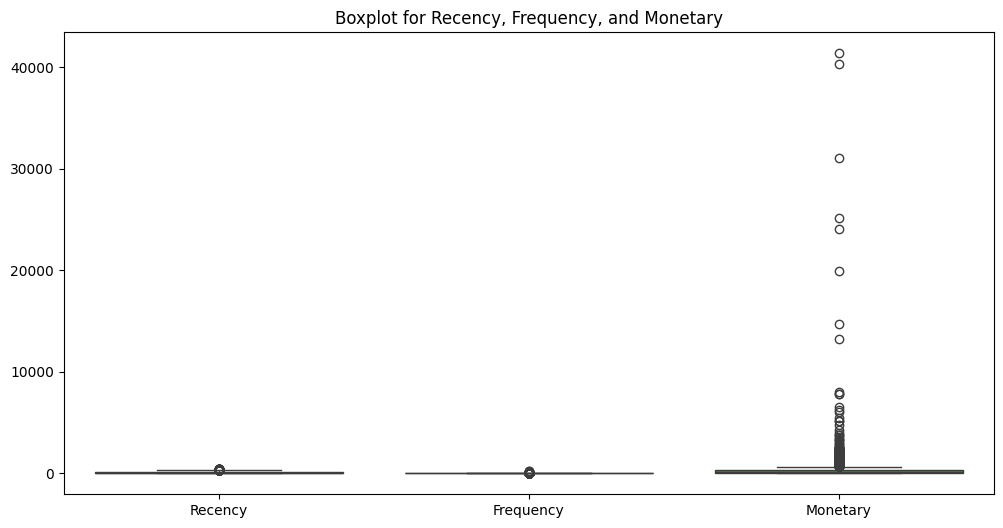

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(data=rfm[['Recency', 'Frequency', 'Monetary']])
plt.title('Boxplot for Recency, Frequency, and Monetary')
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_cleaned_iqr[['Recency', 'Frequency', 'Monetary']])


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [27]:
kmeans = KMeans(n_clusters=4, random_state=0)
rfm_cleaned_iqr['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm_cleaned_iqr.head()


C:\Users\kk061\AppData\Local\Temp\ipykernel_31620\3166722538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_cleaned_iqr['Cluster'] = kmeans.fit_predict(rfm_scaled)


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,2,2.08,1
12347.0,2,7,481.21,0
12348.0,75,4,178.71,2
12349.0,19,1,605.10,3
12350.0,310,1,65.30,1


In [29]:
cluster_summary = rfm_cleaned_iqr.groupby('Cluster').mean()
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,35.672199,7.850622,306.803963
1,232.163429,1.644571,77.932423
2,50.445032,2.179894,84.991277
3,47.988014,3.931507,346.034848


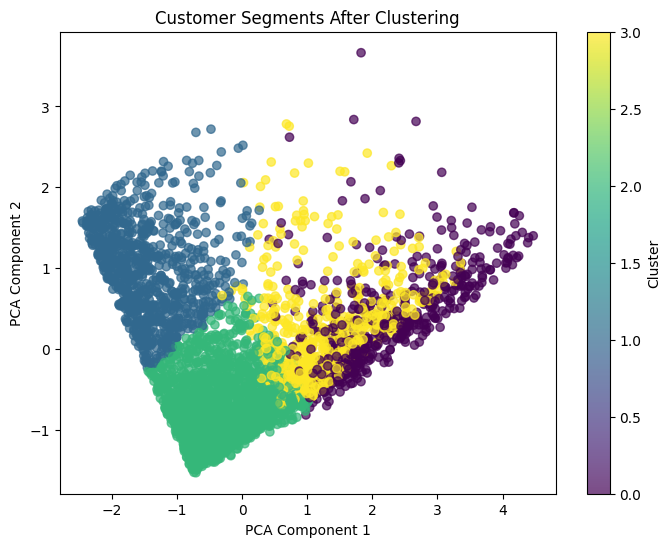

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm_cleaned_iqr['Cluster'], alpha=0.7)
plt.title('Customer Segments After Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()